## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [1]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [3]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [4]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [5]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_\text{eff}= 5778$K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [6]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

In [7]:
### YOUR ANSWER HERE

temps = np.arange(start = 3000, stop = 11000, step = 1000)

B = []
for i in temps:
    B.append(stellar_magnitude(i, "B"))

V = []
for i in temps:
    V.append(stellar_magnitude(i, "V"))

color = np.array(B) - np.array(V)
color


array([ 1.07561236,  0.48474654,  0.13254297, -0.09920957, -0.26167031,
       -0.38079978, -0.4712135 , -0.54175167])

### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [8]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [ ]:
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance


def model_mag(params):

    temp = params[0]
    ext = params[1]
    dist = params[2]

    #### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ

    M = []
    for i in filter_names:
        M.append(stellar_magnitude(temp, i))

    log10 = 5 * np.log10(dist / 10)

    Rlambda = [4.1, 3.1, 2.7, 2.0, 0.9, 0.6, 0.4]
    last_term =  []
    for i in Rlambda:
        last_term.append(ext * i)

    modelmag = np.array(M) + log10 + np.array(last_term)
    return modelmag

    

In [ ]:
def log_likelihood(params, mag, error):
    
        model = model_mag(params)

        chi2 = []
        for i in range(len(model)):
            chi2.append(((mag[i] - model[i])**2 / error[i]**2))
        
        chi2 = np.sum(chi2)

        log_like = -0.5 * chi2
        
        return log_like


def neg_log_likelihood(params, mag, error):
    """Negative log-likelihood for minimization"""
    return -log_likelihood(params, mag, error)


In [11]:
mag = []
for i in synthetic_star:
    mag.append(synthetic_star[i]["true_magnitude"])

error = []
for i in synthetic_star:
    error.append(synthetic_star[i]["error"])

In [12]:
# Use negative log-likelihood for minimization
from scipy.optimize import minimize
result = minimize(
    neg_log_likelihood,
    initial_guess,
    args = (mag, error),
    method = 'Nelder-Mead',
    options = {'maxiter': 10000, 'disp': True}
    )

Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 190
         Function evaluations: 341


In [13]:
params_opt = result.x
params_opt ## [temperature, extinction, distance]

array([6.48976929e+03, 7.98421267e-01, 9.99037393e+01])

In [14]:
model_opt = model_mag(params_opt)
residuals = mag - model_opt

chi2 = np.sum((residuals / error)**2)
dof = len(residuals) - len(params_opt)
reduced_chi2 = chi2 / dof

reduced_chi2

np.float64(3.2497617773102636e-05)

In [15]:
result_hess = minimize(
                neg_log_likelihood,
                params_opt,
                args = (mag, error),
                method = 'L-BFGS-B',
                options = {'disp': False})

In [16]:
result_hess

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 6.499523554611196e-05
        x: [ 6.490e+03  7.984e-01  9.990e+01]
      nit: 1
      jac: [ 1.500e-08  2.897e-04 -3.572e-08]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [17]:
param_errors = np.sqrt(np.diag(np.linalg.inv(result_hess.hess_inv.todense())))
param_errors

array([1., 1., 1.])

In [18]:
params_hess = result_hess.x
params_hess

array([6.48976929e+03, 7.98421267e-01, 9.99037393e+01])

### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

In [26]:
### YOUR ANSWER HERE

synth_stars = []
synth_stars_ig = []

for i in range(1000):
    np.random.seed(seed = i)
    Bmag = np.random.choice(np.arange(12.369 - 0.02, 12.369 + 0.02, 0.0002))
    Vmag = np.random.choice(np.arange(11.756 - 0.03, 11.756 + 0.03, 0.0003))
    Rmag = np.random.choice(np.arange(11.553 - 0.04, 11.553 + 0.04, 0.0004))
    Imag = np.random.choice(np.arange(11.149 - 0.05, 11.149 + 0.05, 0.0005))
    Jmag = np.random.choice(np.arange(10.616 - 0.06, 10.616 + 0.06, 0.0006))
    Hmag = np.random.choice(np.arange(10.609 - 0.07, 10.609 + 0.07, 0.0007))
    Kmag = np.random.choice(np.arange(10.762 - 0.08, 10.762 + 0.08, 0.0008))

    synth_star = { 'B': {'magnitude': Bmag, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': Vmag, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': Rmag, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': Imag, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': Jmag, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': Hmag, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': Kmag, 'error': 0.08, 'true_magnitude': 10.762} }
    
    Gtemp = np.random.choice(np.arange(4000, 6000, 1))
    Gav = np.random.choice(np.arange(0.25, 0.75, 0.002))
    Gdist = np.random.choice(np.arange(25, 125, 0.1))

    initialguess = [Gtemp, Gav, Gdist]  # Temperature, A_V, Distance
    
    synth_stars.append(synth_star)
    synth_stars_ig.append(initialguess)

In [27]:
result_params = []

for i in synth_stars_ig:

    result1 = minimize(
        neg_log_likelihood,
        i,
        args = (mag, error),
        method = 'Nelder-Mead',
        options = {'maxiter': 10000, 'disp': True}
        )
    
    result_params.append(result1)

Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 193
         Function evaluations: 343
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 228
         Function evaluations: 399
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 183
         Function evaluations: 335
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 171
         Function evaluations: 307
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 219
         Function evaluations: 398
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 224
         Function evaluations: 390
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 340
         Function evaluations: 585
Optimization termina

In [37]:
chi2_errors = []
hess_results = []
hess_errors = []

for i in result_params:
    params = i.x

    model_opt = model_mag(params)
    residuals = mag - model_opt

    chi2 = np.sum((residuals / error)**2)
    dof = len(residuals) - len(params_opt)
    reduced_chi2 = chi2 / dof

    chi2_errors.append(reduced_chi2)

    result_hess = minimize(
                neg_log_likelihood,
                params,
                args = (mag, error),
                method = 'L-BFGS-B',
                options = {'disp': False})
    hess_results.append(result_hess.x)
    
    param_errors = np.sqrt(np.diag(np.linalg.inv(result_hess.hess_inv.todense())))
    hess_errors.append(param_errors)


In [31]:
np.mean(chi2_errors)

np.float64(3.24976177737985e-05)

In [ ]:
np.mean(hess_errors[:][0]), np.mean(hess_errors[:][1]), np.mean(hess_errors[:][2]) ## temp, AV, dist errors

(np.float64(1.0), np.float64(1.0), np.float64(1.0))

In [ ]:
true_params = [6500, 0.8, 100]

In [44]:
temp_bias = []
for i in range(len(hess_results)):
    temp_bias.append(hess_results[i][0] - true_params[0])

av_bias = []
for j in range(len(hess_results)):
    av_bias.append(hess_results[j][1] - true_params[1])

dist_bias = []
for k in range(len(hess_results)):
    temp_bias.append(hess_results[k][2] - true_params[2])

In [46]:
np.mean(temp_bias), np.mean(av_bias), np.mean(dist_bias)

(np.float64(-5.163497798678688),
 np.float64(-0.0015787363011123255),
 np.float64(nan))

### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

In [47]:
## YOUR ANSWER HERE

true_params2 = [6500, 0.8, 98]

def log_prior(params):
    """
    Prior probability distributions for parameters
    Assumes uniform priors within reasonable bounds
    """
    temp, av, dist = params

    # Define reasonable bounds
    if not (5000 < temp < 7000):
        return -np.inf
    if not (0.1 < av < 5):
        return -np.inf
    if not (93 < dist < 103):
        return -np.inf

    return 0  # Uniform prior (log(1) = 0)

def log_posterior(params, mag, error):
    """Log posterior probability"""
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood(params, mag, error)
    return lp + ll

In [51]:
def log_probability(theta, mag, error):
    """
    Calculate the log-posterior probability.
    This is what emcee will sample.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, mag, error)

In [48]:
ndim = 3  # Number of parameters
nwalkers = 30  # Number of walkers (should be >> ndim)
nsteps = 10000  # Number of steps per walker

# Initial positions: add small random scatter around a guess
initial_guess = np.array([6000, 0.9, 95])  
pos = initial_guess + 1e-1 * np.random.randn(nwalkers, ndim)

In [49]:
import emcee

In [65]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, 
    args = (mag, error)
)

sampler.run_mcmc(pos, nsteps, progress=False, store = True)

# Get the acceptance fraction
print(f"\nMean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")


Mean acceptance fraction: 0.557


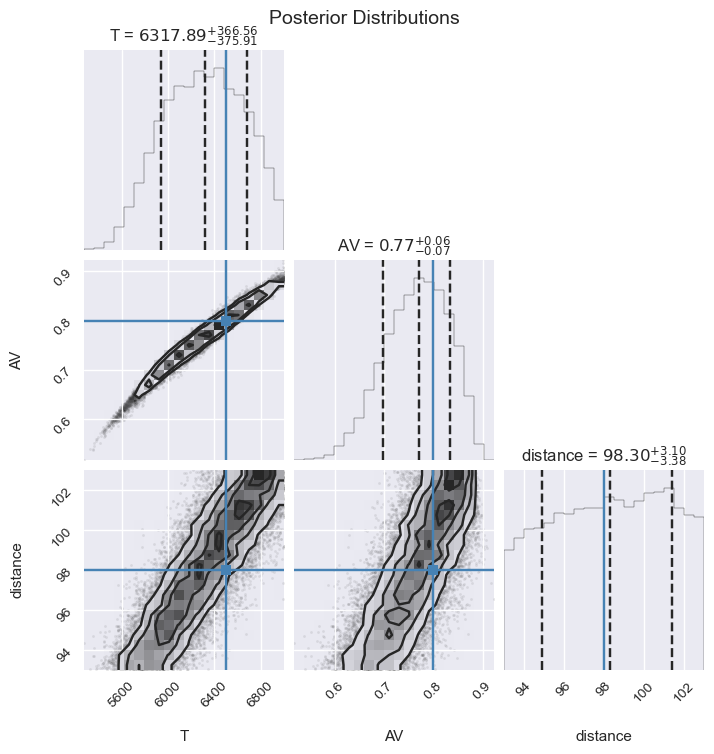

In [71]:
import corner
labels = ["T", "AV", "distance"]
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

fig = corner.corner(
    flat_samples,
    labels=labels,
    truths=true_params2,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

plt.suptitle('Posterior Distributions', 
             y=1.0, fontsize=14)
plt.show()

In [56]:
mag

[12.369, 11.756, 11.553, 11.149, 10.616, 10.609, 10.762]

In [58]:
mag_rijhk = mag[2:]
mag_bvrij = mag[:5]

In [67]:
## RIJHK

def model_mag2(params):

    temp = params[0]
    ext = params[1]
    dist = params[2]

    #### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ

    M = []
    for i in filter_names[2:]:
        M.append(stellar_magnitude(temp, i))

    log10 = 5 * np.log10(dist / 10)

    Rlambda = [2.7, 2.0, 0.9, 0.6, 0.4]
    last_term =  []
    for i in Rlambda:
        last_term.append(ext * i)

    modelmag = np.array(M) + log10 + np.array(last_term)
    return modelmag


def log_likelihood2(params, mag, error):
    
        model = model_mag2(params)

        chi2 = []
        for i in range(len(model)):
            chi2.append(((mag[i] - model[i])**2 / error[i]**2))
        
        chi2 = np.sum(chi2)

        log_like = -0.5 * chi2
        
        return log_like


def log_probability2(theta, mag, error):
    """
    Calculate the log-posterior probability.
    This is what emcee will sample.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood2(theta, mag, error)


sampler2 = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability2, 
    args = (mag_rijhk, error[2:])
)

sampler2.run_mcmc(pos, nsteps, progress=False, store = True)

# Get the acceptance fraction
print(f"\nMean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")


Mean acceptance fraction: 0.557


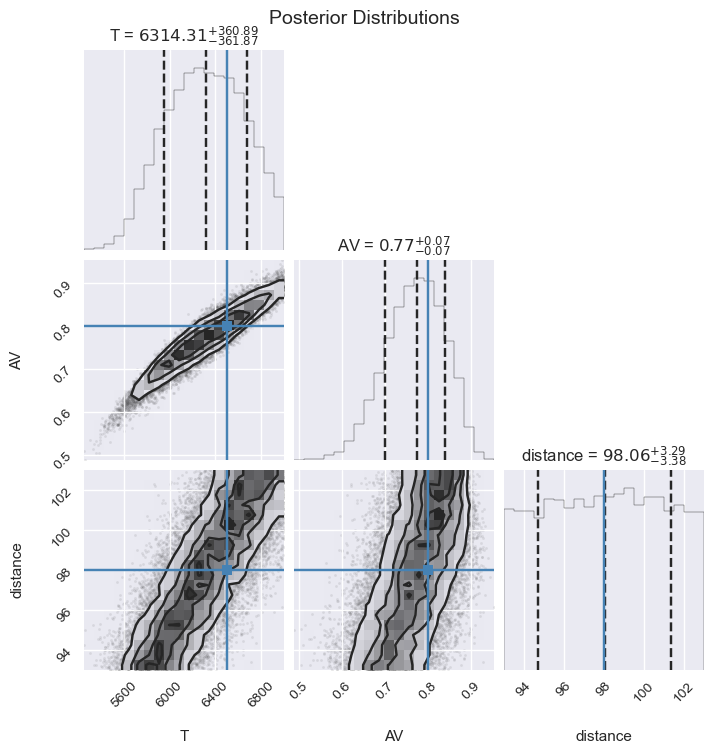

In [68]:
flat_samples2 = sampler2.get_chain(discard=1000, thin=15, flat=True)

fig = corner.corner(
    flat_samples2,
    labels=labels,
    truths=true_params2,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

plt.suptitle('Posterior Distributions', 
             y=1.0, fontsize=14)
plt.show()

In [69]:
## BVRIJ

def model_mag3(params):

    temp = params[0]
    ext = params[1]
    dist = params[2]

    #### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ

    M = []
    for i in filter_names[:5]:
        M.append(stellar_magnitude(temp, i))

    log10 = 5 * np.log10(dist / 10)

    Rlambda = [4.1, 3.1, 2.7, 2.0, 0.9]
    last_term =  []
    for i in Rlambda:
        last_term.append(ext * i)

    modelmag = np.array(M) + log10 + np.array(last_term)
    return modelmag


def log_likelihood3(params, mag, error):
    
        model = model_mag3(params)

        chi2 = []
        for i in range(len(model)):
            chi2.append(((mag[i] - model[i])**2 / error[i]**2))
        
        chi2 = np.sum(chi2)

        log_like = -0.5 * chi2
        
        return log_like


def log_probability3(theta, mag, error):
    """
    Calculate the log-posterior probability.
    This is what emcee will sample.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood3(theta, mag, error)


sampler3 = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability3, 
    args = (mag_rijhk, error[:5])
)

sampler3.run_mcmc(pos, nsteps, progress=False, store = True)

# Get the acceptance fraction
print(f"\nMean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")


Mean acceptance fraction: 0.557


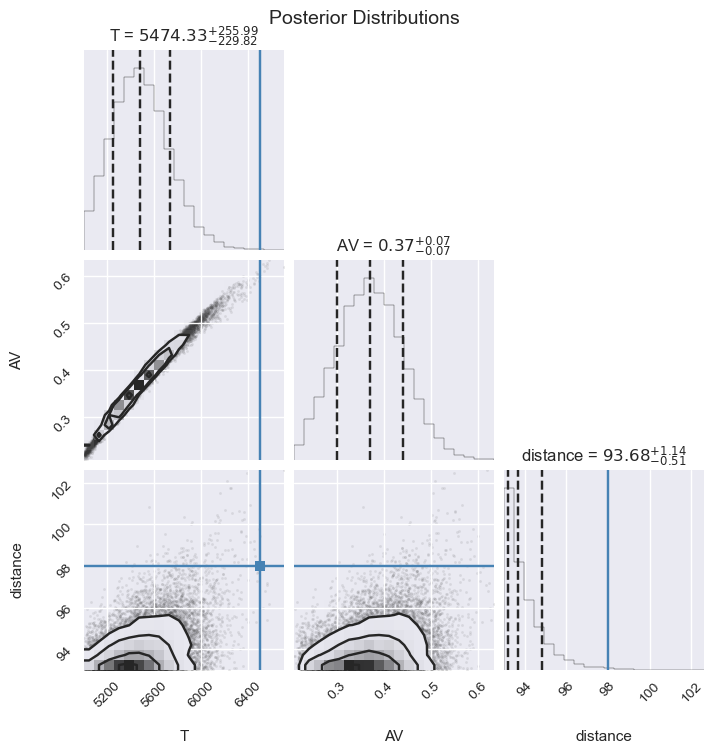

In [70]:
flat_samples3 = sampler3.get_chain(discard=1000, thin=15, flat=True)

fig = corner.corner(
    flat_samples3,
    labels=labels,
    truths=true_params2,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

plt.suptitle('Posterior Distributions', 
             y=1.0, fontsize=14)
plt.show()



-The BVRIJ MCMC is quite far from the true values; for RIJHK and all bands the sampler does an okay job getting its samples around / near the true values

-AV and temperature decrease with fewer bands